In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
import shapely.geometry
import shapely.ops as so

In [22]:
# Position
x0 = 0
xf = 30
xobs = [[5, 7], [10, 11], [15, 16], [23, 25]]
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
K = 1000
iter_max = 1000
tMax = 20
vmax = 2
max_time = 5

# Obstacle Setting
# [start, close, open]
obs1 = [0, 2.5, 2.5]
obs2 = [0, 4, 4]
obs3 = [0, 3, 3]
obs4 = [0, 8, 2.5]
obs_vec = [obs1, obs2, obs3, obs4]
# obs_vec = [[0, 7.32055774028567, 2.67944225971433], [0, 8.365554423062276, 1.6344455769377237], [0, 6.5278658685643665, 3.4721341314356335], [0, 3.2779829401524174, 6.722017059847582], [0, 7.589851271623784, 2.4101487283762157], [0, 5.642641646419559, 4.357358353580441]]

In [49]:
"""Initial Setup"""
# Position
x0 = 0
xf = 40
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
K = 10000
iter_max = 1000
tMax = 20
vmax = 2
max_time = 5

def generate_map():
    # Obstacle Setting
    num_obs = rn.randint(8, 10)
    # num_obs = 8
    xobs_thickness = []
    for i in range(num_obs):
        xobs_thickness.append(rn.uniform(0.5,2))
    xobs = []
    while len(xobs) < num_obs:
        for i in range(num_obs):
            if len(xobs) == num_obs:
                break
            temp = rn.uniform(x0+1, xf-3)
            xobs_i = [temp, temp+xobs_thickness[i]]
            if len(xobs) == 0:
                xobs.append(xobs_i)
            else:
                overlap_check = []
                for ii in range(len(xobs)):
                    if np.abs(xobs_i[0] - xobs[ii][0]) >= 2:
                        overlap_check.append(1)
                    else:
                        overlap_check.append(0)
                if sum(overlap_check) == len(xobs):
                    xobs.append(xobs_i)
    # [start, close, open]
    obs_vec = []
    min_period = 5
    max_period = 20
    for i in range(num_obs):
        random_period = rn.uniform(min_period, max_period)
        thickness_i = xobs_thickness[i]
        temp = rn.uniform((thickness_i/vmax)+2, random_period-2)
        obs_vec.append([0, temp, random_period-temp])
    return num_obs, xobs, obs_vec

In [50]:
num_obs, xobs, obs_vec = generate_map()
print(num_obs)
print(xobs)
print(obs_vec)

8
[[9.709965150994645, 10.731087942075748], [4.415961446833881, 5.449737921984052], [14.465671516728934, 15.09095577965709], [16.99723671106875, 18.281834874727593], [27.42746707874805, 28.111826632389967], [31.49960750084379, 32.52073029192489], [24.660148705417008, 25.94474686907585], [6.829036355748869, 7.850159146829972]]
[[0, 3.283220505538078, 4.953057081363272], [0, 8.276198001564657, 6.912212501090174], [0, 6.05819168765224, 3.7860086270236835], [0, 8.830180807647015, 9.505825401813699], [0, 11.191125902071555, 6.102707605652391], [0, 7.886070717163996, 3.849559491947913], [0, 13.249998629519427, 2.5362268259973764], [0, 4.001681635517741, 11.50395714716008]]


In [24]:
def distance(a, b):
    return b - a

In [4]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [5]:
def reachable_RRTC(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    
    if dx == 0:
        return True
    else:
        if forward and np.abs(dx/dt) <= vmax and dt > 0:
            return True
        elif not forward and np.abs(dx/dt) <= vmax and dt < 0:
            return True
        return False

In [6]:
def random_sample_RRTC(tf, n, k):
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal and n == 1:
        # IF not, sample goal
        if np.mod(k, 2) == 0: # Start from bottom tree (x0)
            xrand = xf
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = x0
            trand = 0
    elif not sample_goal or n >= 1:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        if n == 1:
            xrand = rand_points[0][0]
            trand = rand_points[0][1]
            return [xrand, trand]
        else:
            return rand_points
    return [xrand, trand]

In [7]:
def extend(qclosest, q1, max_time):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    max_distance = max_time

    if np.abs(dx) <= max_distance and np.abs(dt) <= max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2 + dt**2)
        dxnorm = dx/norm*max_distance
        dtnorm = dt/norm*max_distance
        qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

In [8]:
def find_neighbor_RRTC(qrand, V, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,2) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, forward):
            dist_vec.append(distance(V[i][0], qrand[0]))
        else:
            dist_vec.append(1e100)

    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [9]:
def check_route_test(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [10]:
def find_path_test(vi, vf, V, E, trigger):
    # trigger:
    # 0 -> a
    # 1 -> b
    path_vec = []
    path_vec.append(vf)
    curr = vf
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                if trigger == 0:
                    curr = E[ei][0]
                else:
                    curr = E[ei][0]
                path_vec.append(curr)
                break
        kek += 1

        if trigger == 0:
            if curr[0] == vi[0] and curr[1] == vi[1]:
                return path_vec
        elif trigger == 1:
            if np.abs(curr[0]-vi[0]) <= 0.1:
                return path_vec
            

In [51]:
# Standard ST-RRT-Connect
RRTC_total_time = []
RRTC_total_distance = []
time_vec_RRTC = []
iter = 0
iter_max = 1

K = 2500
success_RRTC = 0
tf = xf/vmax + 10
while iter < iter_max:
    print('iter: ', iter)
    start = time.time()
    t_test = []
    V_RRTConnect = {}
    E_RRTConnect = {}
    kk = 0
    while 1:
        tmax = tf
        print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCa_raw = []
        V_RRTCb = []
        V_RRTCb.append([xf, tf])
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        while k < K:
            t_check = []
            print('k: ', k)
            while 1:
                # Sample
                sample_start = time.time()
                qrand = random_sample_RRTC(tf, 1, k)
                # print('sample time: ', time.time()-sample_start)
                t_check.append(time.time()-sample_start)

                neighbor_start = time.time()
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
                # print('neighbor check time: ', time.time()-neighbor_start)
                t_check.append(time.time()-neighbor_start)
                
                if qclosest is not None:
                    extend_start = time.time()
                    qnew = extend(qclosest, qrand, max_time)
                    # adfadfaf
                    # print('extend time: ', time.time()-extend_start)
                    t_check.append(time.time()-extend_start)
                        
                    # Validate
                    validate_start = time.time()
                    check_vec = validate(qnew)
                    # print('validation time: ', time.time()-validate_start)
                    t_check.append(time.time()-validate_start)
                    if np.sum(check_vec) == 0:
                        check_route_start = time.time()
                        kek = check_route_test(qclosest, qnew, tf)
                        # print('route_check: ', time.time()-check_route_start)
                        t_check.append(time.time()-check_route_start)
                        # print('total: ', time.time()-sample_start)
                        if kek:
                            break
                
            # Add V, E
            add_start = time.time()
            if np.mod(k, 2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
                V_RRTCa_raw.append(qrand)
            else:
                V_RRTCb.append(qnew)
                E_RRTCb.append([qclosest, qnew])
                T_RRTCb.append(qnew[1])
                V_RRTCb_raw.append(qrand)
            # print('Add time: ', time.time()-add_start)
            t_check.append(time.time()-add_start)

            # Check continue
            connection_start = time.time()
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tf) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            success_RRTC += 1
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[-1], forward=False):
                        if check_route_test(vi, V_RRTCb[-1], tf) and reachable_RRTC(vi, V_RRTCb[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb[-1]]
                            path_check = True
                            success_RRTC += 1
                            break
            # print('path_check: ', time.time()-path_check_start)
            t_check.append(time.time()-connection_start)
            # print('total from sample: ', time.time()-sample_start)
            t_test.append(time.time()-sample_start)
            k += 1

            if path_check:
                path_check_start = time.time()
                # print('Path Found')
                path_start = time.time()
                E_RRTC = E_RRTCa + E_RRTCb
                E_RRTC.append(connect_edge)
                patha_start = time.time()
                patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
                t_check.append(time.time()-patha_start)
                # print('Path a: ', time.time()-patha_start)
                pathb_start = time.time()
                pathb = find_path_test([xf, tf], E_RRTC[-1][1], V_RRTCb, E_RRTCb, 1)
                t_check.append(time.time()-pathb_start)
                # print('Path b: ', time.time()-pathb_start)
                final_path = list(reversed(patha)) + pathb
                # print('path compute: ', time.time()-path_start)
                total_path_time = 0
                total_path_distance = 0
                for fpv in range(len(final_path)-1):
                    total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                    total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
                RRTC_total_time.append(total_path_time)
                RRTC_total_distance.append(total_path_distance)
                break
        V_RRTConnect[str(kk)] = [V_RRTCa, V_RRTCb]
        E_RRTConnect[str(kk)] = [E_RRTCa, E_RRTCb]

        # print('Path_check: ', path_check)
        if tf >= (xf/vmax + 50) or path_check:
            break
        tf += 10
        kk += 1

    end = time.time()
    # print('final time: ', end-start)
    
    time_vec_RRTC.append(end-start)
    iter += 1

    # if end-start >= 10:
    #     break

print('Average Computation Time (sec): ', sum(time_vec_RRTC)/len(time_vec_RRTC))
if path_check:
    print('Average Path Time (sec): ', sum(RRTC_total_time)/len(RRTC_total_time))
    print('Average Path Distance (sec): ', sum(np.abs(RRTC_total_distance))/len(RRTC_total_distance))
print('Success Rate: ', success_RRTC/iter_max)

iter:  0
tf:  30.0
k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36
k:  37
k:  38
k:  39
k:  40
k:  41
k:  42
k:  43
k:  44
k:  45
k:  46
k:  47
k:  48
k:  49
k:  50
k:  51
k:  52
k:  53
k:  54
k:  55
k:  56
k:  57
k:  58
k:  59
k:  60
k:  61
k:  62
k:  63
k:  64
k:  65
k:  66
k:  67
k:  68
k:  69
k:  70
k:  71
k:  72
k:  73
k:  74
k:  75
k:  76
k:  77
k:  78
k:  79
k:  80
k:  81
k:  82
k:  83
k:  84
k:  85
k:  86
k:  87
k:  88
k:  89
k:  90
k:  91
k:  92
k:  93
k:  94
k:  95
k:  96
k:  97
k:  98
k:  99
k:  100
k:  101
k:  102
k:  103
k:  104
k:  105
k:  106
k:  107
k:  108
k:  109
k:  110
k:  111
k:  112
k:  113
k:  114
k:  115
k:  116
k:  117
k:  118
k:  119
k:  120
k:  121
k:  122
k:  123
k:  124
k:  125
k:  126
k:  127
k:  128
k:  129
k:  130
k:  131
k:  132
k:  133
k:  134
k:  135
k: 

164.03877186775208


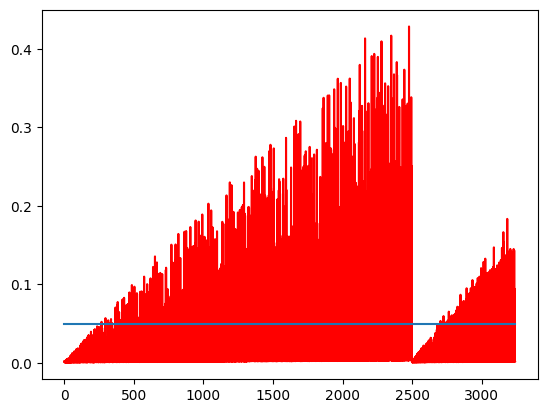

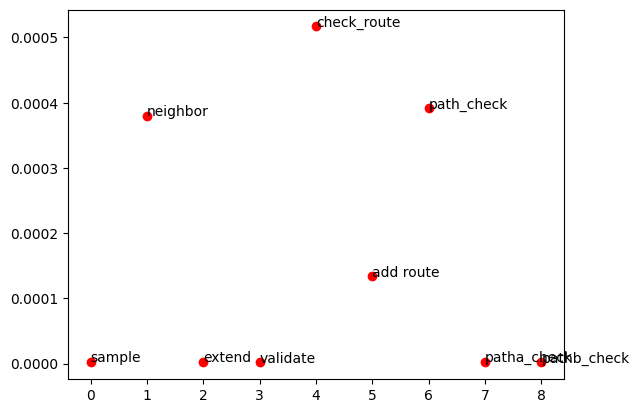

In [52]:
fig = plt.figure()
xvec = np.linspace(0, len(t_test)-1, len(t_test))
plt.plot(xvec, t_test, '-r')
plt.plot([0, len(xvec)], [0.05, 0.05])
print(np.sum(t_test))

legend_vec = ['sample', 'neighbor', 'extend', 'validate', 'check_route', 'add route', 'path_check', 'patha_check', 'pathb_check']
fig = plt.figure()
xvec = np.linspace(0, len(legend_vec)-1, len(legend_vec))
for i in range(len(xvec)):
    plt.plot(xvec[i], t_check[i], 'or')
    plt.text(xvec[i], t_check[i], legend_vec[i])

Text(0, 0.5, 't')

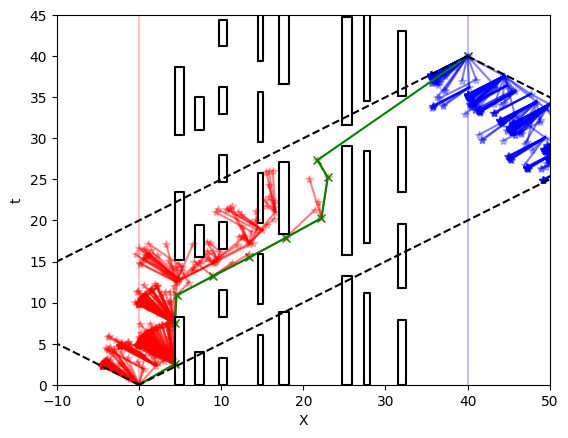

In [53]:
fig = plt.figure()
ax = fig.subplots()
# RRTConnect
for rrtv in V_RRTCa:
   plt.plot(rrtv[0], rrtv[1], 'r*', alpha=0.25)
for rrtv in V_RRTCb:
   plt.plot(rrtv[0], rrtv[1], 'b*', alpha=0.25)
# for rrtvr in V_RRTCa_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'm.', alpha=0.25)
# for rrtvr in V_RRTCb_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'c.', alpha=0.25)
for rrte in E_RRTCa:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.5)
for rrte in E_RRTCb:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.5)
if final_path is not None:
    for pathi in final_path:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(final_path)-1):
        plt.plot([final_path[ii][0], final_path[ii+1][0]], [final_path[ii][1], final_path[ii+1][1]], '-g')


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
# plt.xlim(point3[0]-5, point4[0]+5)
plt.xlim(x0-10, xf+10)
plt.ylim(0, tf+5)
# plt.xlim(25, 35)
# plt.ylim(30, 45)
plt.xlabel('X')
plt.ylabel('t')

In [ ]:
# Test out modification:
# Do RRT with tf estimated (i.e. RRT-Connect without goal tree)
# See & Compare which contributes more in computation time: sample domain size vs tree growing on both side
# Idea on time shadow + thorough analysis on RRT-Connect and other methods
# Compare: when updating tf, does increased sampling size increase computation time? does double-sided tree growth help reducing time or not?

Text(0, 0.5, 't (sec)')

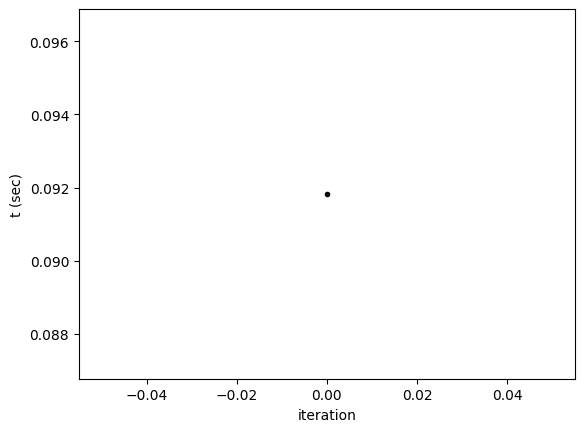

In [37]:
fig = plt.figure()
xaxis = np.linspace(0, len(time_vec_RRTC)-1, len(time_vec_RRTC))
plt.plot(xaxis, time_vec_RRTC, '.k')
plt.xlabel('iteration')
plt.ylabel('t (sec)')

# xaxis = np.linspace(0, len(time_vec_RRTC)-3, len(time_vec_RRTC)-2)
# time_vec_RRTC_nooutlier = time_vec_RRTC
# time_vec_RRTC_nooutlier.remove(max(time_vec_RRTC))
# time_vec_RRTC_nooutlier.remove(max(time_vec_RRTC_nooutlier))

# fig = plt.figure()
# plt.plot(xaxis, time_vec_RRTC_nooutlier, '.k')
# plt.xlabel('iteration')
# plt.ylabel('t (sec)')

# print('Average Computation Time (sec): ', sum(time_vec_RRTC_nooutlier)/len(time_vec_RRTC_nooutlier))

ST-RRT-Connect with Time-Shadow

In [38]:
"""ST-RRT with Time Shadow"""
def isInside(A, B, C, x, y):
    # Decomposition
    x1 = A[0]
    y1 = A[1]
    x2 = B[0]
    y2 = B[1]
    x3 = C[0]
    y3 = C[1]

    c1 = (x2-x1)*(y-y1)-(y2-y1)*(x-x1)
    c2 = (x3-x2)*(y-y2)-(y3-y2)*(x-x2)
    c3 = (x1-x3)*(y-y3)-(y1-y3)*(x-x3)
    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        # In Triangle
        return True
    else:
        # Not in Triangle
        return False
    
def obstacle_check_timeshadow(q2, obs_pos, obs_t, forward= True):
    trand = q2[1]
    temp = trand - obs_t[0]
    tempt = np.mod(temp, obs_t[1]+obs_t[2])

    if tempt >= obs_t[1] and tempt <= (obs_t[1]+obs_t[2]):
        if forward:
            # Not Caught
            X1 = [obs_pos[0], obs_t[1]+obs_t[2]]
            X2 = [obs_pos[1], obs_t[1]+obs_t[2]]
            X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[0]+(obs_pos[1]-obs_pos[0])/2)/vmax + (X2[1]-X2[0]/vmax)]
        else:
            X1 = [obs_pos[0], obs_t[1]]
            X2 = [obs_pos[1], obs_t[1]]
            X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[0]+(obs_pos[1]-obs_pos[0])/2)/vmax + (X1[1]-X1[0]/vmax)]

        if isInside(X1, X2, X3, q2[0], tempt):
            # Caught
            return False
        else:
            return True
    else:
        # Caught
        return False 
    
def validate_timeshadow(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if np.mod(k,2) == 0:
                if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i], True):
                    check_vec.append(0)
                else:
                    check_vec.append(1)
            else:
                if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i], False):
                    check_vec.append(0)
                else:
                    check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

In [39]:
def time_block_obstacle_timeshadow(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]
    timeblock = shapely.geometry.Polygon([point1, point2, point3, point4])

    # Downward Triangle
    X1 = [pos_obs[0], time_obs[0]+time_obs[1]+time_obs[2]+time_translate]
    X2 = [pos_obs[1], time_obs[0]+time_obs[1]+time_obs[2]+time_translate]
    X3 = [pos_obs[0]+(pos_obs[1]-pos_obs[0])/2, (pos_obs[0]+(pos_obs[1]-pos_obs[0])/2)/vmax + (X2[1]-X2[0]/vmax)]
    downTriangle = shapely.geometry.Polygon([X1, X2, X3])

    # Upward Triangle
    X4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]
    X5 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    X6 = [pos_obs[0]+(pos_obs[1]-pos_obs[0])/2, (pos_obs[0]+(pos_obs[1]-pos_obs[0])/2)/vmax + (X4[1]-X4[0]/vmax)]
    upperTriangle = shapely.geometry.Polygon([X4, X5, X6])

    return so.unary_union([timeblock, downTriangle, upperTriangle])

In [40]:
def check_route_test_timeshadow(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle_timeshadow(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [78]:
# Standard ST-RRT-Connect with Timeshadow
RRT_RS_total_time = []
RRT_RS_total_distance = []
time_vec_RRTC_TS = []
iter = 0
iter_max = 1
K = 25000
success_RRTC_TS = 0
tf = xf/vmax + 30
while iter < iter_max:
    final_path = None
    print('iter: ', iter)
    start = time.time()
    t_test = []
    V_RRTConnect_TS = {}
    E_RRTConnect_TS = {}
    kk = 0
    while 1:
        tmax = tf
        # print('tf: ', tf)
        k = 0
        V_RRTCa_TS = []
        V_RRTCa_TS.append([x0, 0])
        V_RRTCa_TS_raw = []
        V_RRTCb_TS = []
        V_RRTCb_TS.append([xf, tf])
        V_RRTCb_TS_raw = []

        T_RRTCa_TS = []
        T_RRTCb_TS = []
        T_RRTCa_TS.append(0)
        T_RRTCa_TS.append(tf)

        E_RRTCa_TS = []
        E_RRTCb_TS = []

        while k < K:
            t_check = []
            print('k: ', k)
            while 1:
                # Sample
                sample_start = time.time()
                qrand = random_sample_RRTC(tf, 1, k)
                # print('sample time: ', time.time()-sample_start)
                t_check.append(time.time()-sample_start)

                neighbor_start = time.time()
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa_TS, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb_TS, k)
                # print('neighbor check time: ', time.time()-neighbor_start)
                t_check.append(time.time()-neighbor_start)
                
                if qclosest is not None:
                    extend_start = time.time()
                    qnew = extend(qclosest, qrand, max_time)
                    # print('extend time: ', time.time()-extend_start)
                    t_check.append(time.time()-extend_start)
                        
                    # Validate
                    validate_start = time.time()
                    check_vec = validate_timeshadow(qnew)
                    # print('validation time: ', time.time()-validate_start)
                    t_check.append(time.time()-validate_start)
                    if np.sum(check_vec) == 0:
                        check_route_start = time.time()
                        kek = check_route_test_timeshadow(qclosest, qnew, tf)
                        # print('route_check: ', time.time()-check_route_start)
                        t_check.append(time.time()-check_route_start)
                        # print('total: ', time.time()-sample_start)
                        if kek:
                            break
                
            # Add V, E
            add_start = time.time()
            if np.mod(k, 2) == 0:
                V_RRTCa_TS_raw.append(qrand)
                V_RRTCa_TS.append(qnew)
                E_RRTCa_TS.append([qclosest, qnew])
                T_RRTCa_TS.append(qnew[1])
            else:
                V_RRTCb_TS_raw.append(qrand)
                V_RRTCb_TS.append(qnew)
                E_RRTCb_TS.append([qclosest, qnew])
                T_RRTCb_TS.append(qnew[1])
            # print('Add time: ', time.time()-add_start)
            t_check.append(time.time()-add_start)

            # Check continue
            path_check_start = time.time()
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb_TS:
                    if reachable_RRTC(V_RRTCa_TS[-1], vj, forward=True):
                        if check_route_test_timeshadow(V_RRTCa_TS[-1], vj, tf) and reachable_RRTC(V_RRTCa_TS[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa_TS[-1], vj]
                            path_check = True
                            success_RRTC_TS += 1
                            break
            else:
                for vi in V_RRTCa_TS:
                    if reachable_RRTC(vi, V_RRTCb_TS[-1], forward=False):
                        if check_route_test_timeshadow(vi, V_RRTCb_TS[-1], tf) and reachable_RRTC(vi, V_RRTCb_TS[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb_TS[-1]]
                            path_check = True
                            success_RRTC_TS += 1
                            break
            # print('path_check: ', time.time()-path_check_start)
            t_check.append(time.time()-path_check_start)
            # print('total from sample: ', time.time()-sample_start)
            t_test.append(time.time()-sample_start)
            k += 1

            if time.time()-start >= 15:
                break

            if path_check:
                # print('Path Found')
                path_start = time.time()
                E_RRTC_TS = E_RRTCa_TS + E_RRTCb_TS
                E_RRTC_TS.append(connect_edge)
                patha_start = time.time()
                patha = find_path_test([x0, 0], E_RRTC_TS[-1][0], V_RRTCa_TS, E_RRTCa_TS, 0)
                # print('Path a: ', time.time()-patha_start)
                pathb_start = time.time()
                pathb = find_path_test([xf, tf], E_RRTC_TS[-1][1], V_RRTCb_TS, E_RRTCb_TS, 1)
                # print('Path b: ', time.time()-pathb_start)
                final_path = list(reversed(patha)) + pathb
                # print('path compute: ', time.time()-path_start)
                total_path_time = 0
                total_path_distance = 0
                for fpv in range(len(final_path)-1):
                    total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                    total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
                RRT_RS_total_time.append(total_path_time)
                RRT_RS_total_distance.append(total_path_distance)
                break
        V_RRTConnect_TS[str(kk)] = [V_RRTCa_TS, V_RRTCb_TS]
        E_RRTConnect_TS[str(kk)] = [E_RRTCa_TS, E_RRTCb_TS]

        # print('Path_check: ', path_check)
        if tf >= (xf/vmax + 50) or path_check:
            # print('end')
            break

        if time.time()-start >= 15:
            break
        tf += 5
        kk += 1

    end = time.time()
    # print('final time: ', end-start)
    
    time_vec_RRTC_TS.append(end-start)
    iter += 1


print('Average Computation Time (sec): ', sum(time_vec_RRTC_TS)/len(time_vec_RRTC_TS))
print('Average Path Time (sec): ', sum(RRT_RS_total_time)/len(RRT_RS_total_time))
print('Average Path Distance (sec): ', sum(np.abs(RRT_RS_total_distance))/len(RRT_RS_total_distance))
print('Success Rate: ', success_RRTC_TS/iter_max)

iter:  0
k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36
k:  37
k:  38
k:  39
k:  40
k:  41
k:  42
k:  43
k:  44
k:  45
k:  46
k:  47
k:  48
k:  49
k:  50
k:  51
k:  52
k:  53
k:  54
k:  55
k:  56
k:  57
k:  58
k:  59
k:  60
k:  61
k:  62
k:  63
k:  64
k:  65
k:  66
k:  67
k:  68
k:  69
k:  70
k:  71
k:  72
k:  73
k:  74
k:  75
k:  76
k:  77
k:  78
k:  79
k:  80
k:  81
k:  82
k:  83
k:  84
k:  85
k:  86
k:  87
k:  88
k:  89
k:  90
k:  91
k:  92
k:  93
k:  94
k:  95
k:  96
k:  97
k:  98
k:  99
k:  100
k:  101
k:  102
k:  103
k:  104
k:  105
k:  106
k:  107
k:  108
k:  109
k:  110
k:  111
k:  112
k:  113
k:  114
k:  115
k:  116
k:  117
k:  118
k:  119
k:  120
k:  121
k:  122
k:  123
k:  124
k:  125
k:  126
k:  127
k:  128
k:  129
k:  130
k:  131
k:  132
k:  133
k:  134
k:  135
k:  136
k:  1

Text(0, 0.5, 't')

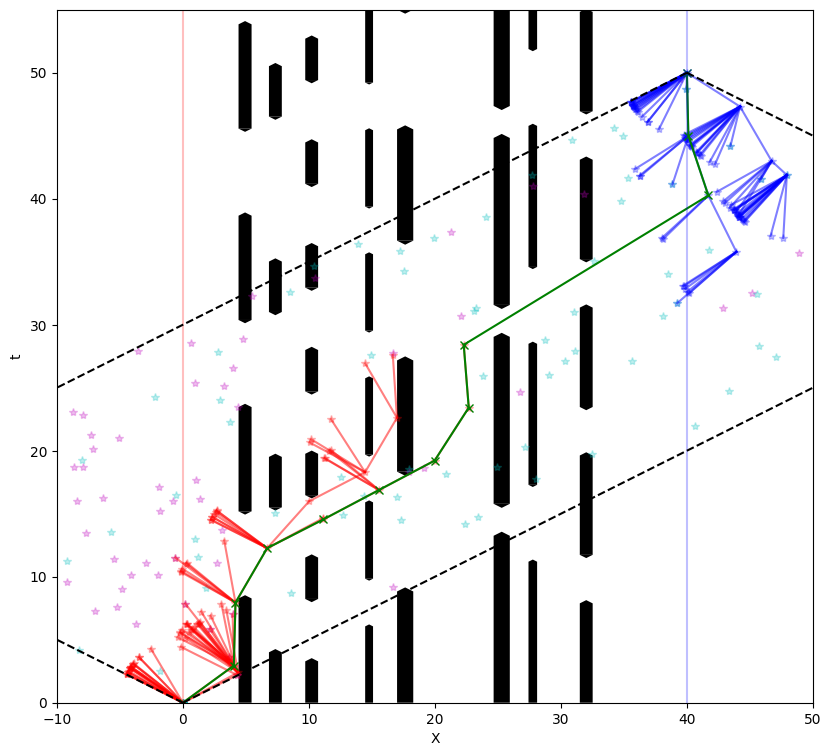

In [81]:
fig = plt.figure(figsize=(16, 9))
ax = fig.subplots()
# RRTConnect
for rrtv in V_RRTCa_TS:
   plt.plot(rrtv[0], rrtv[1], 'r*', alpha=0.25)
for rrtv in V_RRTCb_TS:
   plt.plot(rrtv[0], rrtv[1], 'b*', alpha=0.25)
for rrtv in V_RRTCa_TS_raw:
   plt.plot(rrtv[0], rrtv[1], 'm*', alpha=0.25)
for rrtv in V_RRTCb_TS_raw:
   plt.plot(rrtv[0], rrtv[1], 'c*', alpha=0.25)
for rrte in E_RRTCa_TS:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.5)
for rrte in E_RRTCb_TS:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.5)
if final_path is not None:
    for pathi in final_path:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(final_path)-1):
        plt.plot([final_path[ii][0], final_path[ii+1][0]], [final_path[ii][1], final_path[ii+1][1]], '-g')


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    obs_pos = xobs[i]
    obs_t = obs_vec[i]
    for j in range(obs_number):
        this_obstacle = time_block_obstacle_timeshadow(obs_pos, obs_t, j)
        for geom in this_obstacle.geoms:    
            xs, ys = geom.exterior.xy
            plt.fill(xs, ys, alpha=1, fc='k', ec='none')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
# plt.xlim(-10, 10)
plt.xlim(-10, 50)
plt.ylim(0, tf+5)
# plt.ylim(0, 15)
plt.xlabel('X')
plt.ylabel('t')

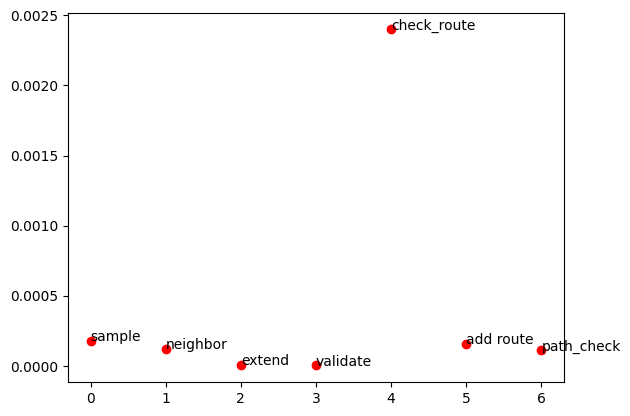

In [80]:
legend_vec = ['sample', 'neighbor', 'extend', 'validate', 'check_route', 'add route', 'path_check']
fig = plt.figure()
xvec = np.linspace(0, len(t_check)-1, len(t_check))
for i in range(len(legend_vec)):
    plt.plot(xvec[i], t_check[i], 'or')
    plt.text(xvec[i], t_check[i], legend_vec[i])

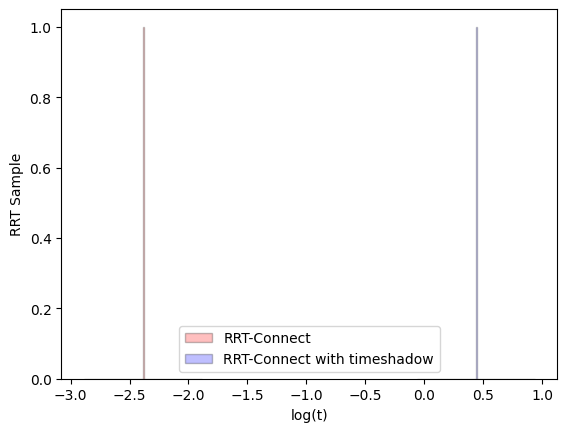

In [44]:
import seaborn as sns
colors = ['r', 'b']
timeVectorForRRTConnect = [time_vec_RRTC, time_vec_RRTC_TS]
fig = plt.figure()
for i in range(len(timeVectorForRRTConnect)):
    plt.hist(np.log(timeVectorForRRTConnect[i]), bins=100, color=colors[i], alpha=0.25, edgecolor = 'black')
plt.xlabel('log(t)')
plt.ylabel('RRT Sample')
plt.legend(['RRT-Connect', 'RRT-Connect with timeshadow'])

Average Computation Time (sec):  1.5505456924438477


Text(0, 0.5, 't (sec)')

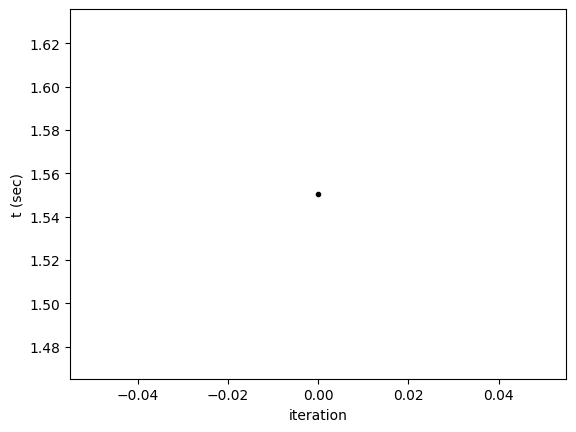

In [45]:
fig = plt.figure()
xaxis = np.linspace(0, len(time_vec_RRTC_TS)-1, len(time_vec_RRTC_TS))
print('Average Computation Time (sec): ', sum(time_vec_RRTC_TS)/len(time_vec_RRTC_TS))
plt.plot(xaxis, time_vec_RRTC_TS, '.k')
plt.xlabel('iteration')
plt.ylabel('t (sec)')

RRT-Connect Modification
- No goal-tree populated with heuristically given final time tf

Aim:
- Compare time contribution for goal tree and expanded sample domain

In [ ]:
def random_sample_RRT(tf):
    n = 1
    sample_goal = rn.uniform(0, 1) <= 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf
        trand = tf
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
    return [xrand, trand]

In [ ]:
def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec

In [ ]:
# Standard ST-RRT
RRT_total_time = []
RRT_total_distance = []
time_vec_RRT = []
iter = 0

success_RRT = 0

while iter < iter_max:
    # Allocate max iteration uniformly
    tf = 20
    maximum_tf = 30
    tf_increment = 5
    tf_iteration = int((maximum_tf-tf)/5+1)
    tf_iteration_vector = []
    for i in range(tf_iteration):
        tf_iteration_vector.append(K//tf_iteration)
    tf_iteration_vector[-1] = (K//tf_iteration + np.mod(K, tf_iteration))

    print('iter: ', iter)
    start = time.time()
    t_test = []
    V_RRT_OneSided = {}
    E_RRT_OneSided = {}
    path_RRT = None
    kk = 0

    # If RRT storages are here, it does not cancel
    V_RRT = []
    V_RRT.append([x0, 0])
    V_RRT_raw = []
    V_RRT_qrand = []

    T_RRT = []
    T_RRT.append(0)

    E_RRT = []
    E_RRT = []
    while 1:
        tmax = tf
        # print('tf: ', tf)
        k = 0
        while k <= tf_iteration_vector[kk]:
            t_check = []
            # print('k: ', k)
            while 1:
                # Sample
                sample_start = time.time()
                qrand = random_sample_RRT(tf)
                V_RRT_qrand.append(qrand)
                # print('sample time: ', time.time()-sample_start)
                t_check.append(time.time()-sample_start)

                neighbor_start = time.time()
                qclosest = find_neighbor_RRTC(qrand, V_RRT, 0)
                # print('neighbor check time: ', time.time()-neighbor_start)
                t_check.append(time.time()-neighbor_start)
                
                if qclosest is not None:
                    extend_start = time.time()
                    qnew = extend(qclosest, qrand, max_time)
                    # adfadfaf
                    # print('extend time: ', time.time()-extend_start)
                    t_check.append(time.time()-extend_start)
                        
                    # Validate
                    validate_start = time.time()
                    check_vec = validate(qnew)
                    # print('validation time: ', time.time()-validate_start)
                    t_check.append(time.time()-validate_start)
                    if np.sum(check_vec) == 0:
                        check_route_start = time.time()
                        kek = check_route_test(qclosest, qnew, tf)
                        # print('route_check: ', time.time()-check_route_start)
                        t_check.append(time.time()-check_route_start)
                        # print('total: ', time.time()-sample_start)
                        if kek:
                            break
            # Add V, E
            add_start = time.time()
            V_RRT.append(qnew)
            V_RRT_raw.append(qrand)
            E_RRT.append([qclosest, qnew])
            T_RRT.append(qnew[1])
            # print('Add time: ', time.time()-add_start)
            t_check.append(time.time()-add_start)
            k += 1
            # Check continue
            dist_check = []
            if np.abs(distance(xf, qnew[0])) <= 1:
                dist_check.append(1)
            else:
                dist_check.append(0)
            if np.sum(dist_check) > 0:
                dist_to_fin = distance(xf, qnew[0])
                qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
                V_RRT.append(qfin)
                E_RRT.append([qnew, qfin])
                path_RRT = find_path(xf, E_RRT)
                success_RRT += 1
                total_path_time = 0
                total_path_distance = 0
                for fpv in range(len(path_RRT)-1):
                    total_path_time += (path_RRT[fpv+1][1]-path_RRT[fpv][1])
                    total_path_distance += np.abs(path_RRT[fpv+1][0]-path_RRT[fpv][0])
                RRT_total_time.append(total_path_time)
                RRT_total_distance.append(total_path_distance)
                break
        V_RRTConnect[str(kk)] = V_RRT
        E_RRTConnect[str(kk)] = E_RRT
        if tf >= maximum_tf:
            break
        else:
            tf += tf_increment
            kk += 1

    end = time.time()
    # print('final time: ', end-start)
    
    time_vec_RRT.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec_RRT)/len(time_vec_RRTC))
if path_RRT is not None:
    print('Average Path Time (sec): ', sum(RRT_total_time)/len(RRT_total_time))
    print('Average Path Distance (sec): ', sum(np.abs(RRT_total_distance))/len(RRT_total_distance))
print('Success Rate: ', success_RRT/iter_max)


iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
iter:  39
iter:  40
iter:  41
iter:  42
iter:  43
iter:  44
iter:  45
iter:  46
iter:  47
iter:  48
iter:  49
iter:  50
iter:  51
iter:  52
iter:  53
iter:  54
iter:  55
iter:  56
iter:  57
iter:  58
iter:  59
iter:  60
iter:  61
iter:  62
iter:  63
iter:  64
iter:  65
iter:  66
iter:  67
iter:  68
iter:  69
iter:  70
iter:  71
iter:  72
iter:  73
iter:  74
iter:  75
iter:  76
iter:  77
iter:  78
iter:  79
iter:  80
iter:  81
iter:  82
iter:  83
iter:  84
iter:  85
iter:  86
iter:  87
iter:  88
iter:  89
iter:  90
iter:  91
iter:  92
iter:  93
iter:  94
iter:  95
iter:  96
iter:  97
iter:  98
iter:  99
iter:  100

In [ ]:
print('Average Path Time (sec): ', sum(RRT_total_time)/len(RRT_total_time))
print('Average Path Distance (sec): ', sum(np.abs(RRT_total_distance))/len(RRT_total_distance))

Average Path Time (sec):  -27.40697479728091
Average Path Distance (sec):  30.359213120837598


Text(0, 0.5, 't')

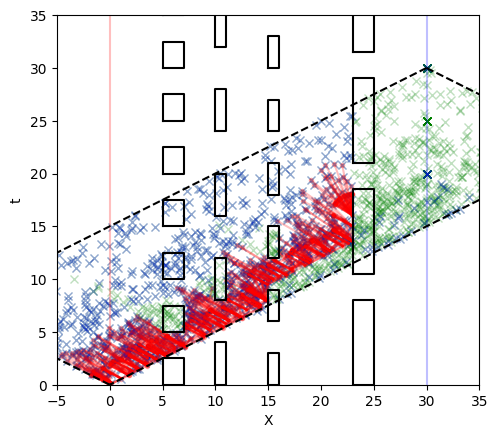

In [ ]:
fig = plt.figure()
ax = fig.subplots()
# RRT
for rrtv in V_RRT:
    plt.plot(rrtv[0], rrtv[1], 'r.', alpha=0.25)
for rrtv in V_RRT_qrand:
    plt.plot(rrtv[0], rrtv[1], 'gx', alpha=0.25)
for rrtv in V_RRT_raw:
    plt.plot(rrtv[0], rrtv[1], 'bx', alpha=0.25)
for rrte in E_RRT:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

Path
if path_RRT is not None:
    for pathi in path_RRT:
        plt.plot(pathi[0], pathi[1], '.g')
    for pathi in range(len(path_RRT)-1):
        plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-g')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
plt.xlim(-5, 35)
plt.ylim(0, tf+5)
plt.xlabel('X')
plt.ylabel('t')